In [10]:
# Imports
%reset -f
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import wandb
import torch.optim as optim
from datasets.CactusDataset import CactusDataset
from models.LeNet5 import LeNet5
from torch.utils.data import ConcatDataset
import os


Image shape: (32, 32, 3)
Image python class<class 'PIL.JpegImagePlugin.JpegImageFile'>
Label: 1
[13136, 4364]


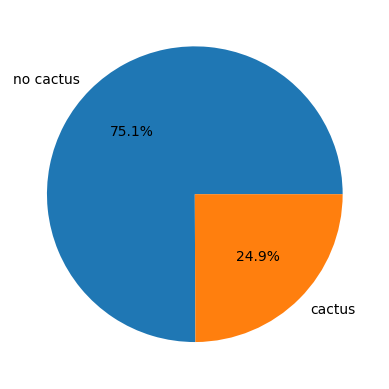

In [11]:
def get_label_distribution(dataset):
    label_counts = {}
    for _, _, label in dataset:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    sorted_distribution = sorted(label_counts.items(), key=lambda x: x[0], reverse=True)
    # take only the count
    return [x[1] for x in sorted_distribution]


# load data for displaying
dataset = CactusDataset(root_dir='./data/train/train',labels_path='./data/train.csv')
# take the first sample from train_dataloader
_, train_features, train_labels = dataset[0]
image_np = np.array(train_features)
print("Image shape: "+str(image_np.shape))
print("Image python class"+str(type(train_features)))
print("Label: "+str(train_labels))

label_distribution = get_label_distribution(dataset) # they are sorted in ascending order
print(label_distribution)
fig, ax = plt.subplots()
ax.pie(label_distribution, labels=['no cactus','cactus'], autopct='%1.1f%%')
plt.show()

Image python class<class 'torch.Tensor'>
Image shape: torch.Size([3, 32, 32])
Label shape: 1


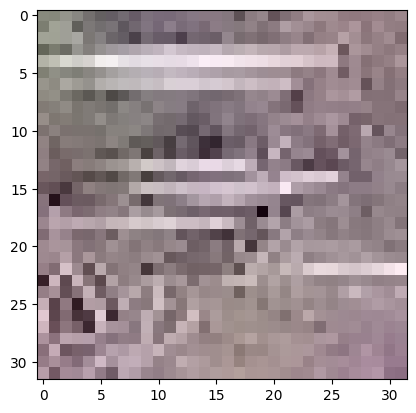

In [12]:
transform_dataset = transforms.Compose([
    transforms.ToTensor()
])

dataset = CactusDataset(
    root_dir="./data/train/train",
    labels_path="./data/train.csv",
    transform=transform_dataset 
)
_, image, label = dataset[0]
print("Image python class" + str(type(image)))
print("Image shape: " + str(image.shape))
print("Label shape: " + str(label))
# show the image
plt.imshow(image.permute(1,2,0))

In [13]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

for i, (img_name, images, labels) in enumerate(dataloader):
    print("Batch number: " + str(i))
    print("Batch image names: " + str(img_name))
    print("Batch images shape: " + str(images.shape))
    print("Batch labels shape: " + str(labels.shape))
    break

Batch number: 0
Batch image names: ('./data/train/train/849c6e33c14e13953abd22b0f5a30d27.jpg', './data/train/train/4de62fb95dccdfce09c34b294768b43f.jpg', './data/train/train/970cfcd6878fd9652d1b97823334c3c2.jpg', './data/train/train/e47b2ba8156da929cbc409bf9ea59301.jpg', './data/train/train/4b071fe7b769fd3750ff2ba9d33d29d9.jpg', './data/train/train/eba48b3fe21bfa42d30bb9c4db39d9c2.jpg', './data/train/train/375da91f6a06749aad9f400e3c3eb9b1.jpg', './data/train/train/54d46e3a826ddeaeb43433f4de3e5d2b.jpg', './data/train/train/b2761c3f32a27dc833dd8015b04ac7fd.jpg', './data/train/train/94d29c428961bc3cb238adaa9d980274.jpg', './data/train/train/d9f4ee6d288c50f5929aca12ee4d9e9b.jpg', './data/train/train/6ad53a0106484b24b0311a8539224e37.jpg', './data/train/train/a6c47c4b0ec60fa6b8e68afe2fc26d19.jpg', './data/train/train/dbc0f6a417490ac94f88ef6d6a46c079.jpg', './data/train/train/26354425b9cf8049ed0f6db3b85b1bf8.jpg', './data/train/train/88b854d14919a9673e301259393290e8.jpg', './data/train/train/

In [14]:
def compute_mean_std(dataset):
    mean = 0.
    std = 0.
    for _, images, _ in dataset:
        mean += images.mean()
        std += images.std()
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

# --------- DATA AUGMENTATION ---------
# filter the dataset to only have no cactus images
dataset = CactusDataset(
    root_dir="./data/train/train",
    labels_path="./data/train.csv",
    transform=transform_dataset
)

no_cactus_dataset = dataset.filter(0)

# create a concatenated dataset with an equal number of cactus and no cactus images
print("**** BEFORE ****")
print("Number of no cactus images: " + str(no_cactus_dataset.__len__()))
print("Number of cactus images: " + str(dataset.__len__()-no_cactus_dataset.__len__()))

mean, std = compute_mean_std(ConcatDataset([dataset, no_cactus_dataset, no_cactus_dataset]))
print("Mean: " + str(mean))
print("Std: " + str(std))

# merged_dataset_transforms=transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.RandomEqualize(1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
# ])

# merged_dataset_transforms=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
# ])

merged_dataset_transforms=transforms.Compose([
    transforms.ToTensor(),
])

dataset = CactusDataset(
    root_dir="./data/train/train",
    labels_path="./data/train.csv",
    transform=merged_dataset_transforms
)

added_dataset = CactusDataset(
    root_dir = "./data/test/test",
    labels_path = "./data/test.csv",
    transform = merged_dataset_transforms
)

print("Added dataset length: " + str(len(added_dataset)))

no_cactus_dataset = dataset.filter(0)
dataset_merged = ConcatDataset([dataset,no_cactus_dataset,no_cactus_dataset])

dataset_merged_len = 0
no_cactus_merged_len = 0
for set in dataset_merged.datasets:
    dataset_merged_len += set.__len__()
    tmp = set.filter(0)
    no_cactus_merged_len += tmp.__len__()

print("\n**** AFTER ****")
print("Number of no cactus images: " + str(no_cactus_merged_len))
print("Number of cactus images: " + str(dataset_merged_len - no_cactus_merged_len))

**** BEFORE ****
Number of no cactus images: 4364
Number of cactus images: 13136
Mean: tensor(0.4809)
Std: tensor(0.1019)
Added dataset length: 4000

**** AFTER ****
Number of no cactus images: 13092
Number of cactus images: 13136


In [15]:
# --------- CREATING THE DATA LOADER AND TRAIN/VAL SPLIT ---------
torch.manual_seed(42)
np.random.seed(42)

dataset_used = dataset_merged
train_size = int(0.8 * len(dataset_used))
print("Train size: " + str(train_size))
test_size = len(dataset_used) - train_size
print("Test size: " + str(test_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset_used, [train_size, test_size])

# train_dataset = ConcatDataset([train_dataset, added_dataset])

# Retrieve the lengths of the datasets
print("dataset length: " + str(len(dataset_used)))
print("train length:" + str(len(train_dataset)))
print("val length:" + str(len(val_dataset)))


# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,pin_memory=True)

#print a sample
_, image,label=dataset_used.__getitem__(0)
print("Image shape: " + str(image.shape))
print("Label shape: " + str(label))

Train size: 20982
Test size: 5246
dataset length: 26228
train length:20982
val length:5246
Image shape: torch.Size([3, 32, 32])
Label shape: 1



 # Phase 2: defining the model

In [16]:
# !! COMMENT THIS CELL IF NOT USING APPLE SILICON CHIP !!

# Metal Performance Shaders Acceleration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

model = LeNet5()
model.to(device)
print(model)

tensor([1.], device='mps:0')
LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
log = True

config = {
    "architecture": "LeNet5-notransf-notest",
    "dataset": "Cactus",
    "epochs": 20,
    "learning_rate": 0.001,
    "batch_size": 32,
    "momentum": 0.9
}

if log:
    # setting wandb
    wandb.login()

Training on: mps
Epoch: 0 Loss train: 0.2581489389512415
Epoch: 0 Loss val: 0.1356004944707199
Epoch: 1 Loss train: 0.2140828055974164
Epoch: 1 Loss val: 0.12813061419533703
Epoch: 2 Loss train: 0.19123630090928978
Epoch: 2 Loss val: 0.13702206817508591
Epoch: 3 Loss train: 0.1798050818228725
Epoch: 3 Loss val: 0.12790404603086844
Epoch: 4 Loss train: 0.16736316610973828
Epoch: 4 Loss val: 0.12232930969571831
Epoch: 5 Loss train: 0.15346864848863806
Epoch: 5 Loss val: 0.11514418214470587
Epoch: 6 Loss train: 0.14253846848862592
Epoch: 6 Loss val: 0.10874790614324813
Epoch: 7 Loss train: 0.13386569261416387
Epoch: 7 Loss val: 0.1038002677254021
Epoch: 8 Loss train: 0.12687750248246174
Epoch: 8 Loss val: 0.10095348491094916
Epoch: 9 Loss train: 0.12091850205853429
Epoch: 9 Loss val: 0.09875555478132943
Epoch: 10 Loss train: 0.1155346799308541
Epoch: 10 Loss val: 0.09527486794927115
Epoch: 11 Loss train: 0.11093987321391904
Epoch: 11 Loss val: 0.09231846729717956
Epoch: 12 Loss train: 0.1

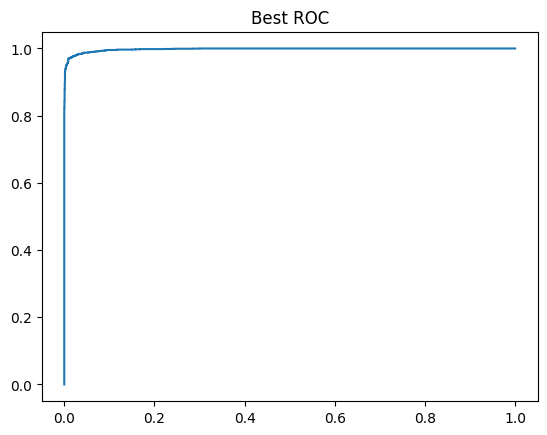

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss train average,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
loss val average,█▇█▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch,19
loss train average,0.09012
loss val average,0.07889


In [18]:
# --------- TRAINING ---------
if log:
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project = "Challenge_1",
    
        # track hyperparameters and run metadata
        config = {
            "architecture": config["architecture"],
            "dataset": config["dataset"],
            "epochs": config["epochs"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "momentum": config["momentum"]
        }
    )
    
    train_dataloader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    if not os.path.exists('./weights/lenet5_model.pth'):
        model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb, freeze=False)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb)
    
    wandb.finish()
else:
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True,pin_memory=True)
    if not os.path.exists('./weights/lenet5_model.pth'):
        model.train_model(train_dataloader, val_dataloader, epochs=config["epochs"], lr=config["learning_rate"], device=device, freeze=False)
    model.train_model(train_dataloader, val_dataloader, epochs=config["epochs"], lr=config["learning_rate"], device=device)